# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity

### 1. Importing libraries and data


In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'AdThxy9-AP2rsqTpRKrx'

In [6]:
# Importing the Federal Reserve Nominal Potential Gross Domestic Product


data = quandl.get('FRED/NGDPPOT')

In [7]:
data.head(5)

,Value
Date,
1949-01-01,274.658161
1949-04-01,275.562222
1949-07-01,277.964165
1949-10-01,281.482290
1950-01-01,284.804425


In [8]:
data.shape

(332, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

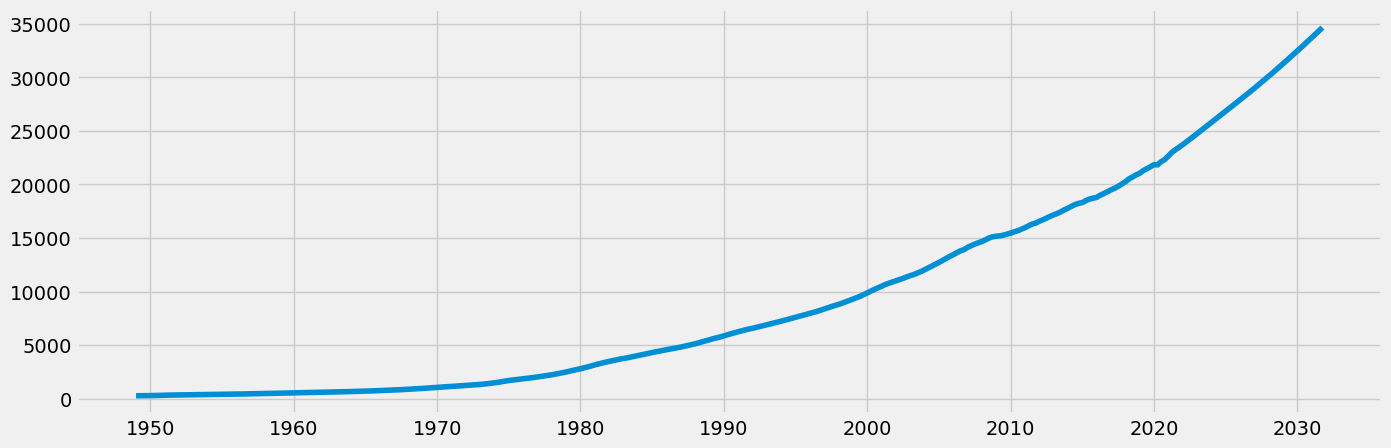

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data


In [12]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1949-01-01,274.658161
1,1949-04-01,275.562222
2,1949-07-01,277.964165
3,1949-10-01,281.482290
4,1950-01-01,284.804425


In [23]:
data_sub = data_2.loc[(data_2['Date'] >= '2018-01-01') & (data_2['Date'] < '2020-12-30')]

I have decided to use this time frame, as in the main dataset we have only information from Jan 2018 till Dec 2020, so we want to see the efect of a lower o bigger GDP in our sales and costs.

In [24]:
data_sub.shape

(12, 2)

In [25]:
data_sub.head()

,Date,Value
276,2018-01-01,20234.99
277,2018-04-01,20503.32
278,2018-07-01,20682.68
279,2018-10-01,20881.05
280,2019-01-01,21035.83


In [26]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2018-01-01,20234.99
2018-04-01,20503.32
2018-07-01,20682.68
2018-10-01,20881.05
2019-01-01,21035.83


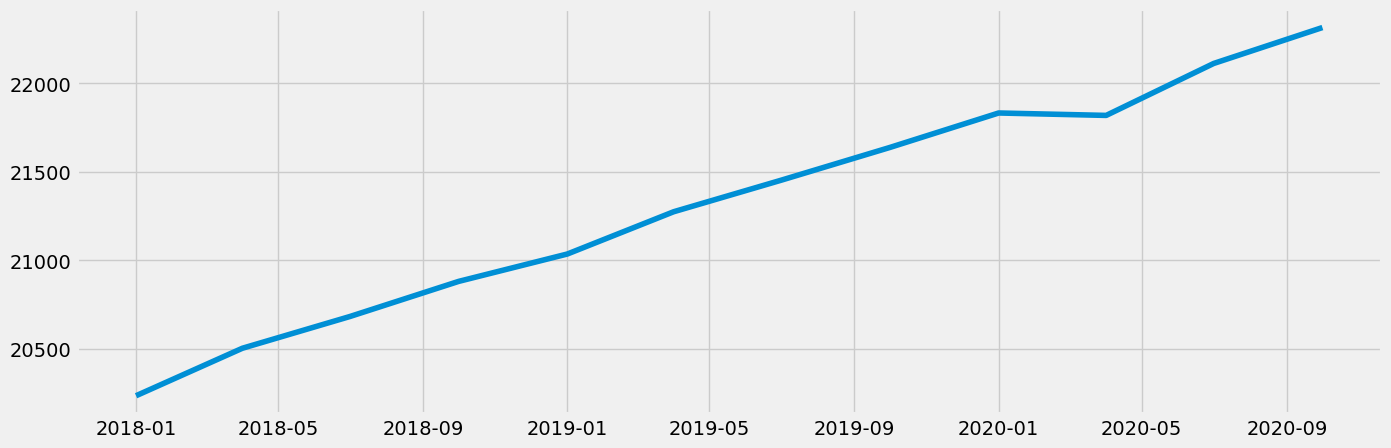

In [27]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [28]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [29]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [30]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [31]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

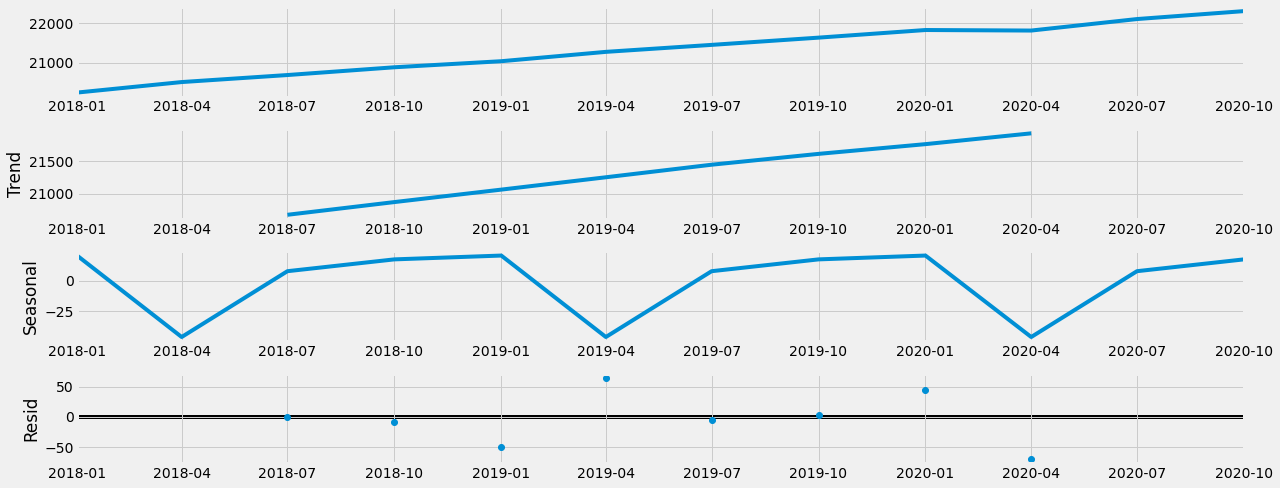

In [32]:
# Plot the separate components

decomposition.plot()
plt.show()

It is super insightful the fact that we can now appretiate a downfall in the GDP in the month of april, having a recovery in july every year

### 4. Testing for stationarity


In [33]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.757596
p-value                        0.401708
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


The result is significant, as we got an p-vale that is < to 0.5

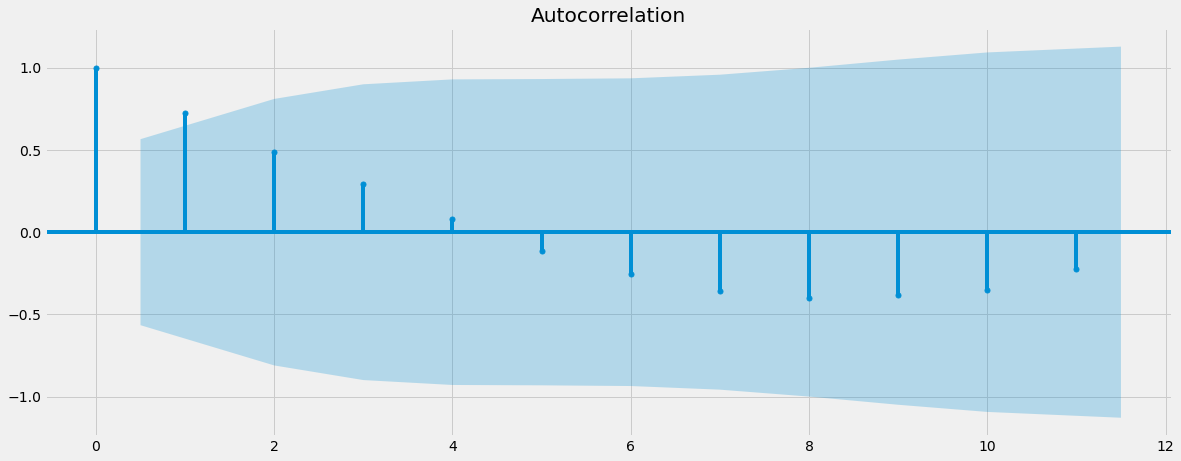

In [34]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

 We dont have a lot of lines that go above the blue edge of the confidence interval, meaning that the lags that are not significantly correlated with each other. So with this data, we dont have to iterate the model once again

We can use this information to see if sales are droping during the period april - july every year and which insights we can pull out of this information